# Imports

In [159]:
import os
from datetime import datetime, timedelta
import pandas as pd
from xgboost import XGBRegressor
import json
import time

import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from xgboost import plot_importance
from matplotlib.patches import Patch

import hopsworks

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Feature Stores Retrieval from Hopsworks

## Login & Retrieve All Feature Stores

In [239]:
project = hopsworks.login(engine="python", project='terahidro2003')
fs = project.get_feature_store()

2025-11-10 18:13:02,333 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-10 18:13:02,337 INFO: Initializing external client
2025-11-10 18:13:02,337 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-10 18:13:03,593 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286307


## Retrieve Air Quality and Wind Feature Stores

In [240]:
pm25_daily_fg = fs.get_feature_group(
    name="pm25_daily",
    version=1
)

wind_direction_hourly_fg = fs.get_feature_group(
    name="wind_direction_hourly",
    version=1
)

wind_speed_hourly_fg = fs.get_feature_group(
    name="wind_speed_hourly",
    version=1
)

air_temperature_hourly_fg = fs.get_feature_group(
    name="air_temperature_hourly",
    version=1
)

# Show what you actually got back for each FG call
print("pm25_daily_fg:", "Loaded" if pm25_daily_fg is not None else "Not Loaded")
print("wind_direction_hourly_fg:", "Loaded" if wind_direction_hourly_fg is not None else "Not Loaded")
print("wind_speed_hourly_fg:", "Loaded" if wind_speed_hourly_fg is not None else "Not Loaded")
print("air_temperature_hourly_fg:", "Loaded" if air_temperature_hourly_fg is not None else "Not Loaded")

pm25_daily_fg: Loaded
wind_direction_hourly_fg: Loaded
wind_speed_hourly_fg: Loaded
air_temperature_hourly_fg: Loaded


# Feature View Creation

Join different feature groups (i.e., pm25, air speed and direction) together.

In [241]:
selected_features = pm25_daily_fg.select(["pm25", "timestamp"]).join(
    wind_direction_hourly_fg.select_features(), on=["region"]
).join(
    wind_speed_hourly_fg.select_features(), on=["region"]
).join(
    air_temperature_hourly_fg.select_features(), on=["region"]
)

2025-11-10 18:13:12,475 INFO: Using ['station_name', 'wind_direction_avg', 'wind_direction_std', 'reading_count', 'latitude', 'longitude', 'hour', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'wind_u', 'wind_v', 'wind_u_lag_1h', 'wind_v_lag_1h', 'wind_direction_lag_1h', 'wind_u_lag_2h', 'wind_v_lag_2h', 'wind_direction_lag_2h', 'wind_u_lag_3h', 'wind_v_lag_3h', 'wind_direction_lag_3h', 'wind_u_lag_6h', 'wind_v_lag_6h', 'wind_direction_lag_6h', 'wind_u_lag_12h', 'wind_v_lag_12h', 'wind_direction_lag_12h', 'wind_u_lag_24h', 'wind_v_lag_24h', 'wind_direction_lag_24h', 'wind_u_lag_48h', 'wind_v_lag_48h', 'wind_direction_lag_48h', 'wind_u_lag_72h', 'wind_v_lag_72h', 'wind_direction_lag_72h', 'wind_u_lag_168h', 'wind_v_lag_168h', 'wind_direction_lag_168h', 'wind_u_rolling_mean_6h', 'wind_v_rolling_mean_6h', 'direction_std_rolling_mean_6h', 'wind_u_rolling_mean_12h', 'wind_v_rolling_mean_12h', 'direction_std_rolling_mean_12h', 'wind_u_rolling_mean_24h', 'wind_v_rolling_mean_2

Create a feature view - selection of features from different feature groups that define I/O API of a model.

In [242]:
feature_view = fs.get_or_create_feature_view(
    name="air_quality_wind_temperature_features",
    version=1,
    description="Feature view with air quality and weather features (wind speed/direction and temperature)",
    labels=['pm25'],
    query=selected_features
)

2025-11-10 18:13:14,373 WARNING: Ambiguous features detected during query construction.The feature `year` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `is_weekend` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `latitude` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `reading_count` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `hour` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `month` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_h

# Splitting the Data into Train/Test Data Sets

In [243]:
start_date = "2025-10-01"

test_start = datetime.strptime(start_date, "%Y-%m-%d")
print("Test data starts from:", test_start.date())

Test data starts from: 2025-10-01


## Split data based on Start Date

In [244]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (13.60s) 
2025-11-10 18:13:54,967 WARNING: VersionWarning: Incremented version to `1`.



### Output Samples from each set

In [245]:
X_train

,timestamp,station_name,wind_direction_avg,wind_direction_std,reading_count,latitude,longitude,hour,day_of_week,day_of_month,...,air_temperature_hourly_air_temperature_rolling_min_24h,air_temperature_hourly_air_temperature_rolling_max_24h,air_temperature_hourly_air_temperature_rolling_mean_72h,air_temperature_hourly_air_temperature_rolling_std_72h,air_temperature_hourly_air_temperature_rolling_min_72h,air_temperature_hourly_air_temperature_rolling_max_72h,air_temperature_hourly_air_temperature_rolling_mean_168h,air_temperature_hourly_air_temperature_rolling_std_168h,air_temperature_hourly_air_temperature_rolling_min_168h,air_temperature_hourly_air_temperature_rolling_max_168h
0,2014-01-29 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-30 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-31 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-02-01 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-02-02 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20732,2025-09-26 00:00:00+00:00,Woodlands Avenue 9,49.641421,0.645412,58.0,1.44387,103.78538,8.0,4.0,26.0,...,26.661667,32.068333,29.109192,1.873100,26.661667,33.451667,28.585812,1.776217,25.545000,33.451667
20733,2025-09-27 00:00:00+00:00,Woodlands Avenue 9,172.548551,0.667131,58.0,1.44387,103.78538,8.0,5.0,27.0,...,27.203448,32.896667,28.947959,1.836293,26.661667,32.896667,28.877399,1.769399,25.758333,33.451667
20734,2025-09-28 00:00:00+00:00,Woodlands Avenue 9,6.156722,0.471423,56.0,1.44387,103.78538,8.0,6.0,28.0,...,26.448333,32.888333,28.859455,2.118963,26.448333,32.896667,28.873405,1.870933,25.758333,33.451667
20735,2025-09-29 00:00:00+00:00,Woodlands Avenue 9,171.290200,0.397990,54.0,1.44387,103.78538,8.0,0.0,29.0,...,25.756667,31.336207,28.586831,2.104045,25.756667,32.896667,28.729708,1.963940,25.756667,33.451667


In [246]:
y_train

,pm25
0,54.0
1,47.0
2,53.0
3,53.0
4,48.0
...,...
20732,69.0
20733,61.0
20734,66.0
20735,28.0


In [247]:
X_features = X_train.drop(columns=['timestamp'])
X_test_features = X_test.drop(columns=['timestamp'])
X_features

,station_name,wind_direction_avg,wind_direction_std,reading_count,latitude,longitude,hour,day_of_week,day_of_month,month,...,air_temperature_hourly_air_temperature_rolling_min_24h,air_temperature_hourly_air_temperature_rolling_max_24h,air_temperature_hourly_air_temperature_rolling_mean_72h,air_temperature_hourly_air_temperature_rolling_std_72h,air_temperature_hourly_air_temperature_rolling_min_72h,air_temperature_hourly_air_temperature_rolling_max_72h,air_temperature_hourly_air_temperature_rolling_mean_168h,air_temperature_hourly_air_temperature_rolling_std_168h,air_temperature_hourly_air_temperature_rolling_min_168h,air_temperature_hourly_air_temperature_rolling_max_168h
0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20732,Woodlands Avenue 9,49.641421,0.645412,58.0,1.44387,103.78538,8.0,4.0,26.0,9.0,...,26.661667,32.068333,29.109192,1.873100,26.661667,33.451667,28.585812,1.776217,25.545000,33.451667
20733,Woodlands Avenue 9,172.548551,0.667131,58.0,1.44387,103.78538,8.0,5.0,27.0,9.0,...,27.203448,32.896667,28.947959,1.836293,26.661667,32.896667,28.877399,1.769399,25.758333,33.451667
20734,Woodlands Avenue 9,6.156722,0.471423,56.0,1.44387,103.78538,8.0,6.0,28.0,9.0,...,26.448333,32.888333,28.859455,2.118963,26.448333,32.896667,28.873405,1.870933,25.758333,33.451667
20735,Woodlands Avenue 9,171.290200,0.397990,54.0,1.44387,103.78538,8.0,0.0,29.0,9.0,...,25.756667,31.336207,28.586831,2.104045,25.756667,32.896667,28.729708,1.963940,25.756667,33.451667


# Modeling

In [249]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

X_features = X_features.select_dtypes(include=["number"]).copy()
X_test_features = X_test_features.select_dtypes(include=["number"]).copy()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [251]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2025-11-10 18:14:36,229 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-10 18:14:36,229 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 133.0129250638362
2025-11-10 18:14:36,230 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-10 18:14:36,230 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: 0.09233644529628326


In [252]:
df = y_test
df['predicted_pm25'] = y_pred

In [253]:
df.head(20)

,pm25,predicted_pm25
4122,30.0,49.216919
4123,44.0,44.647579
4124,43.0,39.612186
4125,32.0,32.663784
4126,49.0,49.145370
4127,52.0,44.255112
4128,49.0,34.817356
4129,43.0,35.670414
4130,37.0,46.264465
4131,49.0,53.372959


In [254]:
X_test

,timestamp,station_name,wind_direction_avg,wind_direction_std,reading_count,latitude,longitude,hour,day_of_week,day_of_month,...,air_temperature_hourly_air_temperature_rolling_min_24h,air_temperature_hourly_air_temperature_rolling_max_24h,air_temperature_hourly_air_temperature_rolling_mean_72h,air_temperature_hourly_air_temperature_rolling_std_72h,air_temperature_hourly_air_temperature_rolling_min_72h,air_temperature_hourly_air_temperature_rolling_max_72h,air_temperature_hourly_air_temperature_rolling_mean_168h,air_temperature_hourly_air_temperature_rolling_std_168h,air_temperature_hourly_air_temperature_rolling_min_168h,air_temperature_hourly_air_temperature_rolling_max_168h
4122,2025-10-01 00:00:00+00:00,Sentosa,70.465618,0.099420,60.0,1.25000,103.82790,8.0,2.0,1.0,...,27.996667,31.041667,28.840023,1.080792,26.695000,31.041667,29.201845,1.243679,26.695000,31.901667
4123,2025-10-02 00:00:00+00:00,Sentosa,300.964991,0.197969,60.0,1.25000,103.82790,8.0,3.0,2.0,...,25.063333,30.671667,28.518981,1.551230,25.063333,31.041667,28.956637,1.491670,25.063333,31.901667
4124,2025-10-03 00:00:00+00:00,Sentosa,215.753478,0.609279,60.0,1.25000,103.82790,8.0,4.0,3.0,...,27.111667,30.540000,28.327894,1.604016,25.063333,31.041667,28.844593,1.496215,25.063333,31.901667
4125,2025-10-04 00:00:00+00:00,Sentosa,250.155750,0.232541,60.0,1.25000,103.82790,8.0,5.0,4.0,...,25.781667,29.921667,27.871528,1.583640,25.063333,30.671667,28.531310,1.499728,25.063333,31.901667
4126,2025-10-05 00:00:00+00:00,Sentosa,69.678954,0.156622,60.0,1.25000,103.82790,8.0,6.0,5.0,...,26.835000,30.735000,28.264306,1.282232,25.781667,30.735000,28.420248,1.404269,25.063333,31.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20769,2025-11-02 00:00:00+00:00,Woodlands Avenue 9,54.400552,0.159841,60.0,1.44387,103.78538,23.0,5.0,1.0,...,25.018333,30.040000,28.070517,2.127279,24.293333,33.138333,28.028873,2.080452,24.293333,33.138333
20770,2025-11-03 00:00:00+00:00,Woodlands Avenue 9,54.400552,0.159841,60.0,1.44387,103.78538,23.0,5.0,1.0,...,25.018333,30.040000,28.070517,2.127279,24.293333,33.138333,28.028873,2.080452,24.293333,33.138333
20771,2025-11-04 00:00:00+00:00,Woodlands Avenue 9,54.400552,0.159841,60.0,1.44387,103.78538,23.0,5.0,1.0,...,25.018333,30.040000,28.070517,2.127279,24.293333,33.138333,28.028873,2.080452,24.293333,33.138333
20772,2025-11-05 00:00:00+00:00,Woodlands Avenue 9,54.400552,0.159841,60.0,1.44387,103.78538,23.0,5.0,1.0,...,25.018333,30.040000,28.070517,2.127279,24.293333,33.138333,28.028873,2.080452,24.293333,33.138333


In [256]:
df['timestamp'] = X_test['timestamp']
df = df.sort_values(by=['timestamp'])
df.head(15)

,pm25,predicted_pm25,day_of_week,timestamp
8271,42.0,57.711967,2.0,2025-10-01 00:00:00+00:00
20737,44.0,43.668587,2.0,2025-10-01 00:00:00+00:00
12430,32.0,54.189960,2.0,2025-10-01 00:00:00+00:00
16579,37.0,56.409039,2.0,2025-10-01 00:00:00+00:00
4122,30.0,49.216919,2.0,2025-10-01 00:00:00+00:00
4123,44.0,44.647579,3.0,2025-10-02 00:00:00+00:00
16580,58.0,58.848408,3.0,2025-10-02 00:00:00+00:00
20738,53.0,57.452015,3.0,2025-10-02 00:00:00+00:00
12431,55.0,58.793545,3.0,2025-10-02 00:00:00+00:00
8272,49.0,61.343605,3.0,2025-10-02 00:00:00+00:00


In [257]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

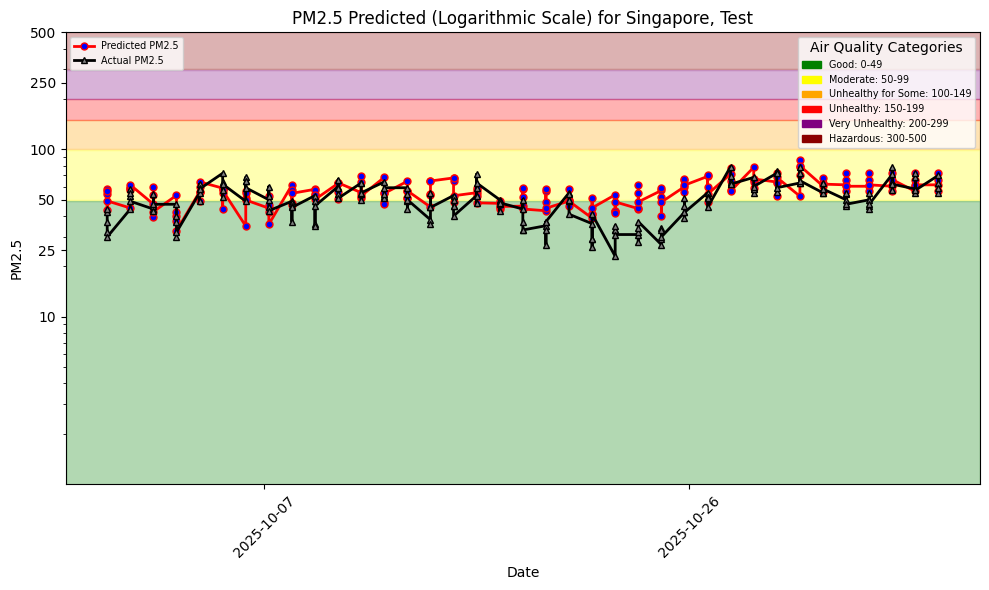

In [259]:
def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['timestamp']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

file_path = images_dir + "/pm25_hindcast.png"
plt = plot_air_quality_forecast('Singapore', 'Test', df, file_path, hindcast=True) 
plt.show()

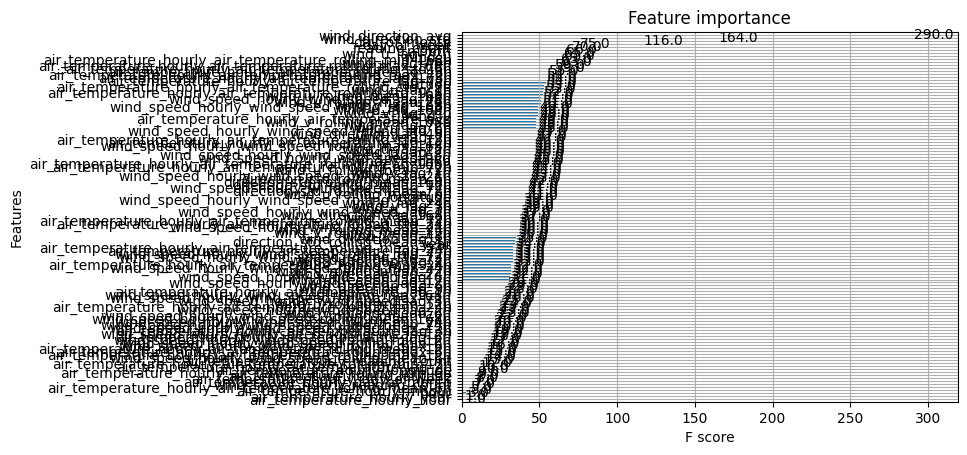

In [260]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()